# NeuroHack 🧠

#### Problem Statement:
---
The language Hinglish involves a hybrid mixing of Hindi and English within conversations, individual sentences and even words.
Eg: “no, it is very difficult even for me." translates to “nahi yaar yeh bahut difficult hai even for me”.

#### Description
---
It is gaining popularity as a way of speaking that demonstrates you are modern, yet locally grounded. There are many datasets available in the English language which are used for research in the NLP field. But nowadays most of the communication takes place in the Hinglish language. It's a very common communication language on social media platforms in India. So to study it in a better way, we have to create machine translation models which can convert English text to Hinglish text. Its purpose will be to help us learn the Hinglish data present on social media servers. It will also help us to secure social media if we are able to create a two way communication between English and Hinglish Language. Accordingly, build a model to translate a given text in the English language into Hinglish language.

#### Imports

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from utils import *
from block import *
import string
from tensorflow.keras.layers import TextVectorization

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Get Data

The function "generate_txt" takes in a file path as input, reads a CSV file at that path and writes the contents of the Hindi and Hinglish columns in that file to a new file called 'train.txt' in utf-8 encoding.

In [5]:
path = r"/content/drive/MyDrive/NeuroHack/data/NeuroHack_train.csv"
generate_txt(path)

#### Split Data

The function "split" takes in a file path as input, reads a file at that path in utf-8 encoding, separates the lines into two lists, one called 'target' and the other called 'cols' where target list contains the even numbered lines with the added "[start] " at the begining and " [end]" at the end and cols list contains the odd numbered lines.

In [6]:
text_path = r"/content/train.txt"
Hinglish, English = split(text_path)

#### Generate Pairs

The function "generate_pairs" takes two lists of strings as input, iterates through each element of the first list and pairs it with the element at the same index in the second list and returns a list of tuple of those pairs.

In [7]:
train_pairs = generate_pairs(English,Hinglish)

In [8]:
train_pairs[0]

('माड्यूल, एक संचिका होती है, जिसमें या तो स्रोत कोड या मशीन भाषा के रूप में अनुदेश निहित होते हैं।\n',
 '[start] module , ek program hoti hai , jismen ya to source code ya machine language ke form men instructions nihit hote hain.\n [end]')

#### Preprocessing Data

In [9]:
# strip_chars = string.punctuation + "¿"
strip_chars = string.punctuation + "\n"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 2531
sequence_length = 153

source_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_hinglish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_hinglish_texts)

In [10]:
batch_size = 64

def format_dataset(eng, hing):
    eng = source_vectorization(eng)
    hing = target_vectorization(hing)
    return ({
        "english": eng,
        "hinglish": hing[:, :-1],
    }, hing[:, 1:])

def make_dataset(pairs):
    eng_texts, hing_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    hing_texts = list(hing_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, hing_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)

In [11]:
for inputs, targets in train_ds.take(1):
    print(f"english\n {inputs['english']}")
    print("------------------------------------------------")
    print(f"hinglish\n {inputs['hinglish']}")

english
 [[ 536    2  536 ...    0    0    0]
 [  86   88    1 ...    0    0    0]
 [  65    1  199 ...    0    0    0]
 ...
 [ 310    1   78 ...    0    0    0]
 [ 651  717  290 ...    0    0    0]
 [ 310 2352   15 ...    0    0    0]]
------------------------------------------------
hinglish
 [[   2 1108    4 ...    0    0    0]
 [   2   93   87 ...    0    0    0]
 [   2   79    1 ...    0    0    0]
 ...
 [   2  276    1 ...    0    0    0]
 [   2  121 1144 ...    0    0    0]
 [   2  276    1 ...    0    0    0]]


#### Architecture

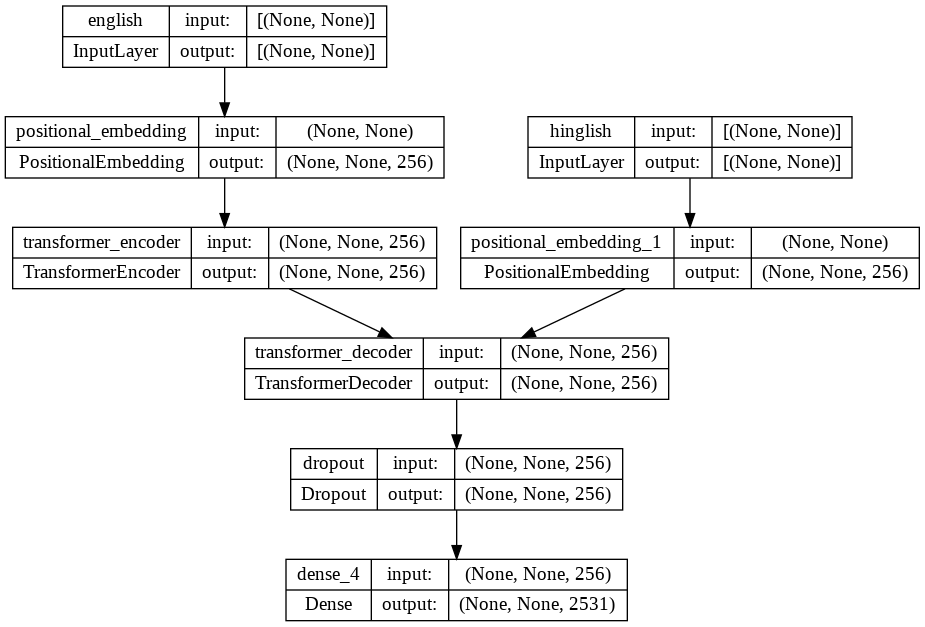

In [12]:
transformer = architecture()

2531 256
2531 256


In [13]:
model_arch(transformer)

In [14]:
history =  build_transformer(transformer,train_ds,epochs=30)

Epoch 1/30
40/41 [============================>.] - ETA: 0s - loss: 0.7516 - accuracy: 0.1955
Epoch 1: saving model to language_translation_checkpoint.hdf5
41/41 [==============================] - 18s 257ms/step - loss: 0.7523 - accuracy: 0.1959
Epoch 2/30
40/41 [============================>.] - ETA: 0s - loss: 0.5862 - accuracy: 0.3890
Epoch 2: saving model to language_translation_checkpoint.hdf5
41/41 [==============================] - 11s 269ms/step - loss: 0.5865 - accuracy: 0.3896
Epoch 3/30
40/41 [============================>.] - ETA: 0s - loss: 0.4058 - accuracy: 0.5956
Epoch 3: saving model to language_translation_checkpoint.hdf5
41/41 [==============================] - 11s 266ms/step - loss: 0.4061 - accuracy: 0.5959
Epoch 4/30
40/41 [============================>.] - ETA: 0s - loss: 0.3008 - accuracy: 0.7008
Epoch 4: saving model to language_translation_checkpoint.hdf5
41/41 [==============================] - 11s 271ms/step - loss: 0.3009 - accuracy: 0.7011
Epoch 5/30
40/41

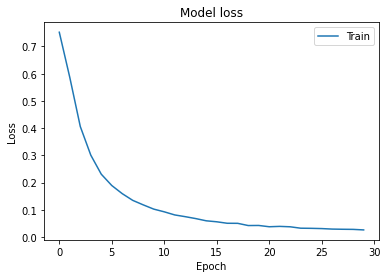

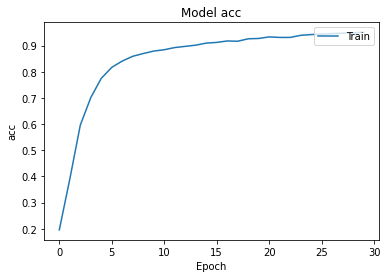

In [15]:
plots(history)

#### Inference

In [28]:
#pip install englisttohindi before running this cell

from englisttohindi.englisttohindi import EngtoHindi

In [31]:
max_decoded_sentence_length = 158 
hing_vocab = target_vectorization.get_vocabulary()
hing_index_lookup = dict(zip(range(len(hing_vocab)), hing_vocab))

def decode_sequences(input_sentence):
  #toekn input
    res = EngtoHindi(input_sentence)
    input_sentence = res.convert
    tokenized_input_sentence = source_vectorization([input_sentence])
  #token input
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = hing_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

In [34]:
from englisttohindi.englisttohindi import EngtoHindi
sentence = "Please can you solve this problem"
output = decode_sequences(sentence)
print(output)

[start] kripya aap is problem ka samadhan kar sakte hain [end]
